In [1]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("../data/train_simple.gzip", compression="gzip")
dataset.shape

(279792, 23)

In [3]:
cat_cols = ["region", "osm_city_nearest_name", "realty_type"]

for col in cat_cols:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])

In [4]:
dataset["floor"] = dataset["floor"].fillna(1)
dataset["city_population"] = dataset["city_population"].fillna(0)

In [5]:
dataset["price_type"] = dataset["price_type"].astype(bool)

In [6]:
dataset.isna().sum().sum()

0

# Split data

In [7]:
target = "per_square_meter_price"
treatment = "price_type"

In [8]:
feature_columns = [
    'city_population',                  # население города
    'total_square',                     # Общая площадь
    'osm_catering_points_in_0.005',     # Кол-во заведений общепита в радиусе 500 метров, OpenStreetMap
    'region',                           # Регион
    'floor',                            # Этаж
    'realty_type',                      # Тип недвижимости (закодирован)
    'osm_crossing_closest_dist',        # Расстояние до ближайшего пешеходного перехода
    'osm_city_nearest_name',            # Название ближайшего города по OpenStreetMap
    'osm_subway_closest_dist',          # Расстояние до ближайщей станции метро, OpenStreetMap
    'reform_mean_floor_count_1000',     # Средняя этажность домов в радиусе 1 км по истоинчку РеформаЖКХ
    'osm_transport_stop_closest_dist',  # Расстояние до ближайщей остановки общественного транспорта, OpenStreetMap
    'osm_amenity_points_in_0.001',      # Кол-во объектов связанных с удобством в радиусе 100 метров, OpenStreetMap
    'osm_city_nearest_population',      # Население ближайшего города по OpenStreetMap
    'lng',                              # Долгота
    'osm_city_closest_dist',            # Расстояние до центра ближайшего города, OpenStreetMap
    'osm_crossing_points_in_0.005',     # Кол-во пешеходных переходов в радиусе 500 метров, OpenStreetMap
    'floor_type',                       # тип этажа
    'lat',                              # Широта
    'reform_mean_year_building_500',    # Среднее значение года постройки домов в радиусе 500 метров по истоинчку РеформаЖКХ
    'osm_culture_points_in_0.005',      # Кол-во объектов культуры в радиусе 500 метров, OpenStreetMap
    'reform_house_population_500',      # Коэффициент количества проживающих людей в радиусе 500 метров по источнику РеформаЖКХ
]

In [9]:
X_train = dataset.loc[dataset[treatment] == 0, feature_columns]
X_test = dataset.loc[dataset[treatment] == 1, feature_columns]

y_train = dataset.loc[dataset[treatment] == 0, target]
y_test = dataset.loc[dataset[treatment] == 1, target]

X_train.shape, X_test.shape

((275299, 21), (4493, 21))

# Model

In [10]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [11]:
%%time

model = CatBoostRegressor(loss_function='RMSE', verbose=0)
model = model.fit(X_train, y_train)

CPU times: user 1min 42s, sys: 2.74 s, total: 1min 45s
Wall time: 15.7 s


# Log target

In [12]:
from sklearn.metrics import make_scorer

In [13]:
def log_rmse(y_true, y_pred):
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))

lrmse_scorer = make_scorer(log_rmse, greater_is_better=False)

In [14]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

### KNN result

In [22]:
%%time

model.fit(
    X_train.iloc[:, :16], 
    y_train_log,
)
y_pred = model.predict(X_test.iloc[:, :16])
log_rmse(y_test_log, y_pred)

CPU times: user 1min 15s, sys: 663 ms, total: 1min 16s
Wall time: 11.6 s


87409.77669857044

### CatBoost result

In [15]:
%%time

model.fit(
    X_train.iloc[:, :16], 
    y_train_log,
)
y_pred = model.predict(X_test.iloc[:, :16])
log_rmse(y_test_log, y_pred)

CPU times: user 1min 51s, sys: 3.58 s, total: 1min 54s
Wall time: 17.1 s


77556.51241913968

# SHAP comparison

#### Feature importance from CatBoost package

In [16]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,city_population,22.098893
1,total_square,15.206572
2,osm_subway_closest_dist,8.546893
3,lng,7.700013
4,osm_city_closest_dist,7.485293
5,osm_catering_points_in_0.005,6.306966
6,reform_mean_floor_count_1000,5.232845
7,osm_city_nearest_population,4.477493
8,realty_type,4.277631
9,osm_crossing_points_in_0.005,4.097371


In [17]:
import shap
from catboost import Pool

In [18]:
shap.initjs()

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_train, y_train))

In [20]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

In [22]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[0:500,:], X_train.iloc[0:500,:])

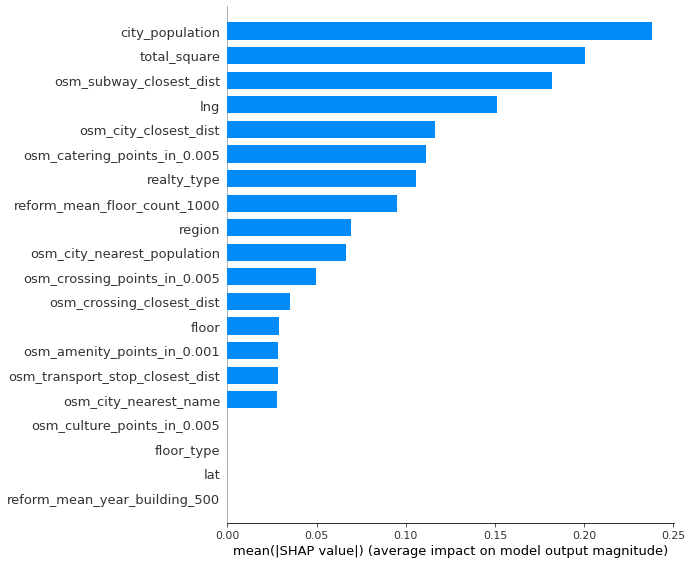

In [23]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

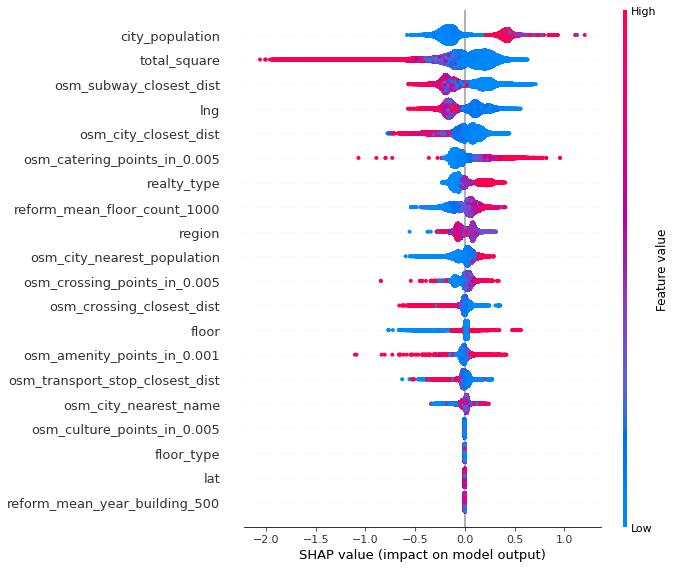

In [24]:
shap.summary_plot(shap_values, X_train)

# Lime

Теперь попробуем просмотреть аналогичные примеры для Lime

In [ ]:
import lime
import lime.lime_tabular
from lime import submodular_pick